Runs parameter sweep over K_charge (10^1 to 10^4) and K_speed (0.125 to 8)

Single transcript population. OEP is present w/ negligible RBS as "control"

Simulations w/ cell fopt = 0.6 are plotted in Roots et al. Sup. fig2

In [17]:
from trnasimtools.serialize import SerializeTwoCodonMultiTranscript
import os

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [3]:
def read_sim(path_pref, seed_start=1, seed_end=3, seed_incr=1, time_limit=None):
    """ 
    Reads in output for an arbitrary number of simulation trials 
    (with different seeds) and concatenates results into a single
    dataset.
    """
    df_master = pd.read_csv(f"{path_pref}_{seed_start}.tsv", sep="\t")
    df_master["seed"] = str(seed_start)
    for i in range(seed_start+1, seed_end+1):
        tmp = pd.read_csv(f"{path_pref}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    if time_limit is not None:
        df_master = df_master[df_master.time < time_limit]
    return df_master
    
def concat_sims(path_pref, max_seed):
    df_master = pd.read_csv(f"{path_pref}_1.tsv", sep="\t")
    df_master["seed"] = str(1)
    for i in range(2, max_seed+1):
        tmp = pd.read_csv(f"{path_pref}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    
    return df_master
    
def get_average_protein(path, perc_good, time, max_seed):
    df_master = concat_sims(path, max_seed)
    df_master["time"] = df_master["time"].apply(np.ceil)
    tmp = df_master.groupby(["time", "species"])["protein", "ribo_density"].mean().reset_index()
    tmp = tmp[(tmp.time > time - 50)] # look at simulations after equilibrium is reached
    tmp["ribo_density_ave"] = tmp[(tmp.species == "cellularProtein")]['ribo_density'].mean()
    tmp = tmp[(tmp.time == time)]
    return tmp

In [4]:
# simulation parameters 
time_limit = 100
time_step = 5
transcript_lens = [1000, 300]
cellular_transcript_copy_number = 100
gfp_transcript_copy_number = 20
ribosome_copy_number = 500
total_trna = 2500
ecol_rbs_rate = 100000.0
ribosome_binding_rate = 0.000001 # GFP with very low binding rate as "control"
trna_charging_rates = [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0, 10000.0]
transcript_names = ["cellularProtein", "GFP"]
trna_composition = [(0.7, 0.3)]
gfp_mrna_compositions = [(0.7, 0.3)]
ribosome_speed = [0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0]
ribosome_footprint = 15

# cell fopts
ecol_mrna_compositions = [(0.2, 0.8), (0.4, 0.6), (0.6, 0.4), (0.7, 0.3), (0.8, 0.2), (1.0, 0)]
date = "june-02-2024"

In [20]:
#!mkdir yaml/june-02-2024
#!mkdir output/june-02-2024

In [21]:
output_dir = "./output"

# write simulation parameters to yaml
for trna_prop in trna_composition:
    for comp in gfp_mrna_compositions:
        for ecol in ecol_mrna_compositions:
            serializer = SerializeTwoCodonMultiTranscript(transcript_lens=transcript_lens,
                                                           codon_comps=[ecol, comp],
                                                           trna_proportion=trna_prop,
                                                           transcript_names=transcript_names,
                                                           time_limit=time_limit,
                                                           time_step=time_step)
            serializer.serialize(f"yaml/{date}")
  
# create simulation batch file
configs = os.listdir(f"yaml/{date}")
with open(f"{date}.txt", "w") as stream:
    for config in configs:
        for speed in ribosome_speed:
            for charging_rate in trna_charging_rates:
                for seed in range(1, 4):
                    cmd = f"python3 ./scripts/twocodonmultitranscript.py ./yaml/{date}/{config} {seed} {cellular_transcript_copy_number} {gfp_transcript_copy_number} " + \
                      f"{ribosome_copy_number} {total_trna} {ecol_rbs_rate} {ribosome_binding_rate} {charging_rate} {charging_rate} " + \
                      f"{output_dir}/{date}/speed_{speed} {speed} {ribosome_footprint}"
                    stream.write(cmd)
                    stream.write("\n")

### Read in simulation outputs 

In [9]:
# reads in simulation output at time = time_limit, takes average over 3 replicates, and appends to a master dataframe
df_master = None

for ecol_codons in ecol_mrna_compositions:
    df_ecol = None
    for charging_rate in trna_charging_rates:
        df_charge = None
        for speed in ribosome_speed:
            df_binding = None
            for codons in gfp_mrna_compositions:
                path = f"output/{date}/speed_{speed}/two_codon_multi_transcript_{ecol_codons[0]}_{ecol_codons[1]}_{codons[0]}_{codons[1]}_0.7_0.3" + \
                       f"_{cellular_transcript_copy_number}_{gfp_transcript_copy_number}_{ribosome_copy_number}_{total_trna}" + \
                       f"_{ecol_rbs_rate}_{ribosome_binding_rate}_{charging_rate}_{charging_rate}"
                tmp = get_average_protein(path, 0.5, 100, 3)
                tmp["codon"] = float(codons[0])
                tmp["species"] = tmp["species"].replace({"__ribosome": "free ribosome"})
                if df_binding is not None:
                    df_binding = df_binding.append(tmp, ignore_index=True)
                else:
                    df_binding = tmp
            df_binding["speed"] = speed
            if df_charge is not None:
                df_charge = df_charge.append(df_binding, ignore_index=True)
            else:
                df_charge = df_binding
        df_charge["charging_rate"] = charging_rate
        if df_ecol is not None:
            df_ecol = df_ecol.append(df_charge, ignore_index=True)
        else:
            df_ecol = df_charge
    df_ecol["ecol"] = ecol_codons[0]
    if df_master is not None:
        df_master = df_master.append(df_ecol, ignore_index=True)
    else:
        df_master = df_ecol
    

df_master = df_master[(df_master.time == 100.0)]
df_master["codon"] = df_master["codon"].div(1).round(1)

/tmp/ipykernel_1210844/288491411.py:30: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tmp = df_master.groupby(["time", "species"])["protein", "ribo_density"].mean().reset_index()


In [10]:
df_master

,time,species,protein,ribo_density,ribo_density_ave,codon,speed,charging_rate,ecol
0,100.0,ATA_charged,102.000000,0.000000,4.935000,0.7,0.125,10.0,0.2
1,100.0,ATA_uncharged,648.000000,0.000000,4.935000,0.7,0.125,10.0,0.2
2,100.0,TTT_charged,1580.333333,0.000000,4.935000,0.7,0.125,10.0,0.2
3,100.0,TTT_uncharged,169.666667,0.000000,4.935000,0.7,0.125,10.0,0.2
4,100.0,__GFP_rbs,20.000000,0.000000,4.935000,0.7,0.125,10.0,0.2
...,...,...,...,...,...,...,...,...,...
2347,100.0,TTT_uncharged,90.333333,0.000000,0.674667,0.7,8.000,10000.0,1.0
2348,100.0,__GFP_rbs,20.000000,0.000000,0.674667,0.7,8.000,10000.0,1.0
2349,100.0,__cellularProtein_rbs,99.333333,0.000000,0.674667,0.7,8.000,10000.0,1.0
2350,100.0,free ribosome,434.666667,0.000000,0.674667,0.7,8.000,10000.0,1.0


In [11]:
df = df_master.pivot_table(index=['speed', 'charging_rate', "ecol"], columns='species', values='protein').reset_index()

df["TTT_charged_perc"] = df["TTT_charged"] / (total_trna*0.7)
df["ATA_charged_perc"] = df["ATA_charged"] / (total_trna*0.3)
df["free_ribosome_perc"] = df["free ribosome"] / ribosome_copy_number

In [12]:
df = df.rename_axis("index", axis=1).reset_index(drop=True)
df = df[(df.ecol == 0.6)]
df = df[["speed", "charging_rate", "free_ribosome_perc", "ATA_charged_perc", "TTT_charged_perc"]]

In [22]:
# final dataframe
df_master.to_csv("speed_vs_charging_grid_search.csv")

In [ ]:
# can uncomment to re-create plots from processed data
# df = pd.read_csv("speed_vs_charging_grid_search.csv")

<AxesSubplot:xlabel='charging_rate', ylabel='speed'>

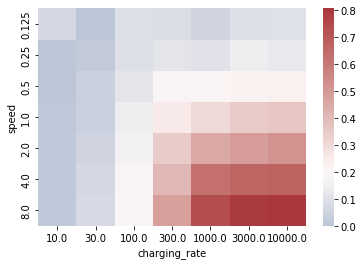

In [14]:
plot_data = df.pivot(index="speed", columns="charging_rate", values="free_ribosome_perc")
sns.heatmap(plot_data, center=0.2, cmap="vlag")

<AxesSubplot:xlabel='charging_rate', ylabel='speed'>

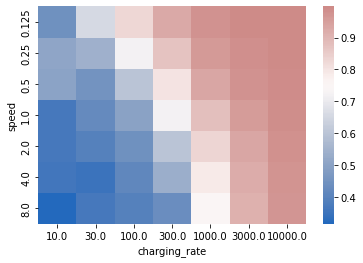

In [15]:
plot_data = df.pivot(index="speed", columns="charging_rate", values="TTT_charged_perc")
sns.heatmap(plot_data, center=0.75, cmap="vlag")

<AxesSubplot:xlabel='charging_rate', ylabel='speed'>

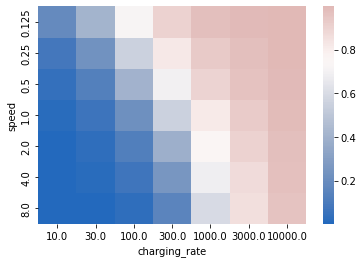

In [16]:
plot_data = df.pivot(index="speed", columns="charging_rate", values="ATA_charged_perc")
sns.heatmap(plot_data, center=0.75, cmap="vlag")